# f₀ and f₁ Diagnostic Analysis

This notebook diagnoses why α → 0 in spatial FDR.

**Goal:** Visualize f₀(p) and f₁(p) to understand what the optimizer sees.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.neighbors import KernelDensity

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Generate Synthetic Data

In [6]:
def generate_spatial_data(n_samples=500, d=2, effect_size=2.0):
    # 80% nulls, 20% alternatives
    n_alt = int(0.2 * n_samples)
    labels = np.zeros(n_samples, dtype=int)
    labels[:n_alt] = 1
    
    # Generate z-scores
    z_scores = np.random.randn(n_samples)
    z_scores[labels == 1] += effect_size
    
    # Convert to p-values
    p_values = 1 - stats.norm.cdf(z_scores)
    
    return labels, p_values

labels, p_values = generate_spatial_data()
print(f'Generated {len(p_values)} p-values')
print(f'True nulls: {np.sum(labels == 0)} (80%)')
print(f'True alternatives: {np.sum(labels == 1)} (20%)')

Generated 500 p-values
True nulls: 400 (80%)
True alternatives: 100 (20%)


## 2. Estimate f₀ and f₁ (Your Current Method)

In [7]:
# PASTE YOUR _estimate_marginal_mixture_robust() HERE
# Or use simplified version below

def estimate_f0_f1(p_values):
    p_clean = p_values[(~np.isnan(p_values)) & (p_values > 0) & (p_values < 1)]
    p_clean = np.clip(p_clean, 1e-15, 1 - 1e-15)
    z_scores = stats.norm.ppf(p_clean)
    
    # Fit KDE
    std_dev = np.std(z_scores)
    bw = 1.06 * std_dev * (len(z_scores) ** (-0.2))
    kde = KernelDensity(bandwidth=bw, kernel='gaussian')
    kde.fit(z_scores.reshape(-1, 1))
    
    def f_z_global(z):
        return np.exp(kde.score_samples(np.atleast_1d(z).reshape(-1, 1)))
    
    # Estimate sigma from right tail
    median_z = np.median(z_scores)
    q75_z = np.percentile(z_scores, 75)
    sigma_est = max(1.0, (q75_z - median_z) / 0.6745)
    delta_est = median_z
    
    print(f'Empirical null: N({delta_est:.3f}, {sigma_est:.3f}²)')
    if sigma_est > 1.1:
        print('  -> Dilated null detected')
    
    def f0(p):
        p_arr = np.atleast_1d(p)
        p_safe = np.clip(p_arr, 1e-15, 1 - 1e-15)
        z = stats.norm.ppf(p_safe)
        pdf_z = stats.norm.pdf(z, loc=delta_est, scale=sigma_est)
        jacobian = 1.0 / np.maximum(stats.norm.pdf(z), 1e-10)
        return pdf_z * jacobian
    
    def f1(p):
        p_arr = np.atleast_1d(p)
        p_safe = np.clip(p_arr, 1e-15, 1 - 1e-15)
        z = stats.norm.ppf(p_safe)
        
        pdf_global = f_z_global(z)
        pdf_null = stats.norm.pdf(z, loc=delta_est, scale=sigma_est)
        
        ratio = pdf_global / (pdf_null + 1e-10)
        pi0_temp = np.min(ratio[z > median_z]) if np.any(z > median_z) else 1.0
        pi0_temp = np.clip(pi0_temp, 0.5, 1.0)
        
        excess = pdf_global - (pi0_temp * pdf_null)
        excess[z > delta_est] = 0
        excess = np.maximum(0, excess)
        
        jacobian = 1.0 / np.maximum(stats.norm.pdf(z), 1e-10)
        return (excess * jacobian) / (1 - pi0_temp + 1e-6)
    
    pi0 = np.clip(np.mean(p_clean > 0.5) / 0.5, 0.1, 1.0)
    print(f'π₀ = {pi0:.3f}')
    
    return f0, f1, pi0

f0, f1, pi0 = estimate_f0_f1(p_values)

Empirical null: N(-0.310, 1.178²)
  -> Dilated null detected
π₀ = 0.804


## 3. Visualize Single Dataset

/tmp/ipykernel_554371/2320810965.py:57: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_554371/2320810965.py:57: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/home/benny/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/home/benny/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


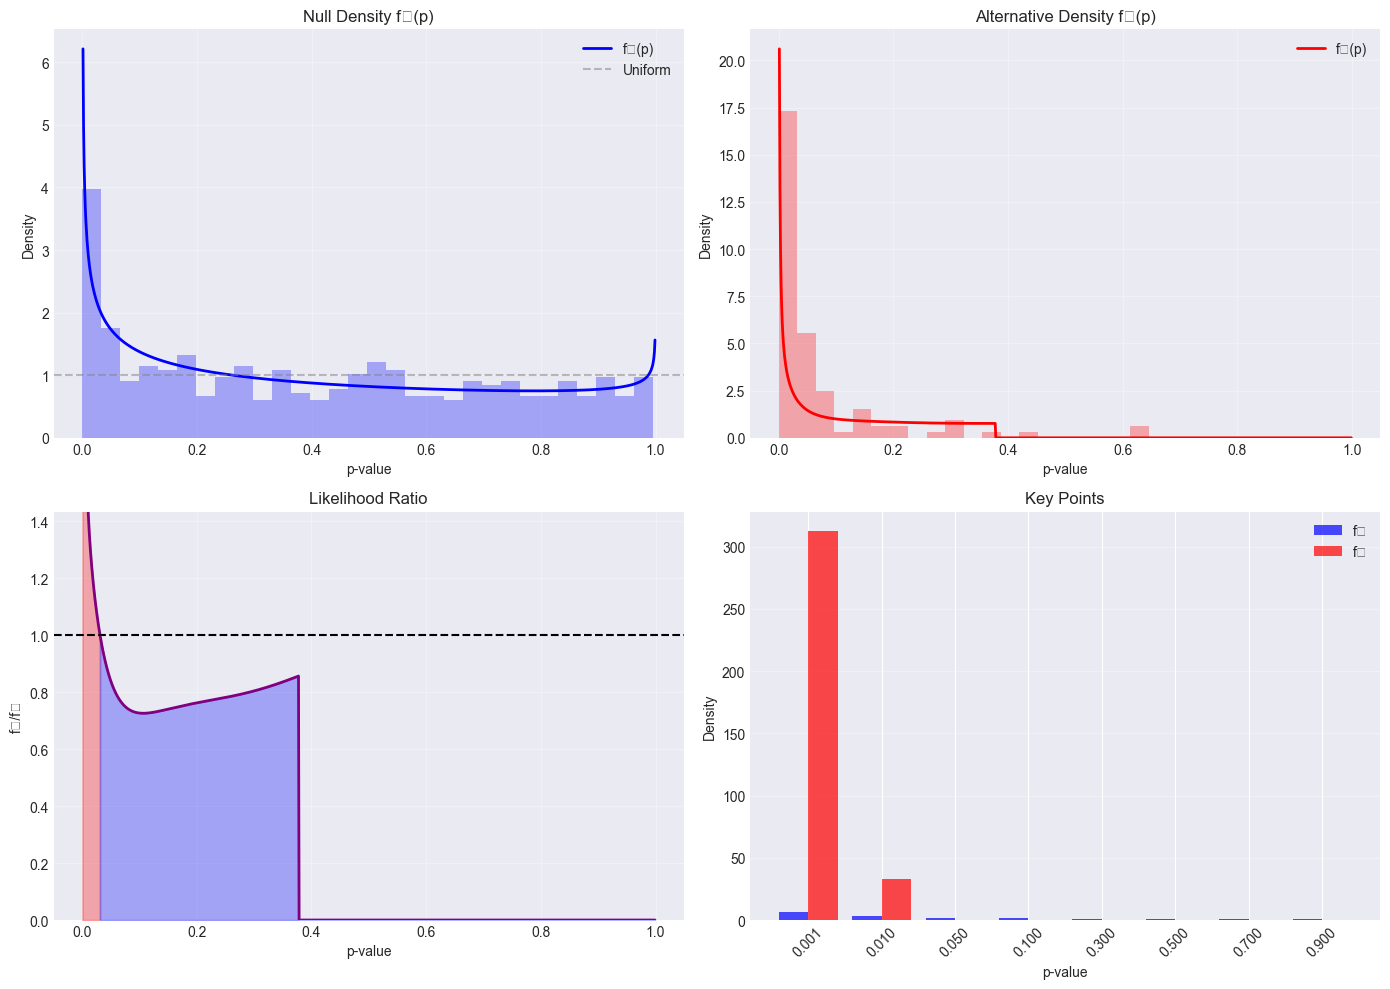


f₁ > f₀ for 3.1% of range
✓ Looks reasonable


In [8]:
p_grid = np.linspace(0.001, 0.999, 1000)
f0_vals = f0(p_grid)
f1_vals = f1(p_grid)
ratio = f1_vals / (f0_vals + 1e-10)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# f0
ax = axes[0, 0]
ax.plot(p_grid, f0_vals, 'b-', linewidth=2, label='f₀(p)')
ax.axhline(1.0, color='gray', linestyle='--', alpha=0.5, label='Uniform')
ax.hist(p_values, bins=30, density=True, alpha=0.3, color='blue')
ax.set_xlabel('p-value')
ax.set_ylabel('Density')
ax.set_title('Null Density f₀(p)')
ax.legend()
ax.grid(True, alpha=0.3)

# f1
ax = axes[0, 1]
ax.plot(p_grid, f1_vals, 'r-', linewidth=2, label='f₁(p)')
ax.hist(p_values[labels == 1], bins=20, density=True, alpha=0.3, color='red')
ax.set_xlabel('p-value')
ax.set_ylabel('Density')
ax.set_title('Alternative Density f₁(p)')
ax.legend()
ax.grid(True, alpha=0.3)

# Ratio
ax = axes[1, 0]
ax.plot(p_grid, ratio, 'purple', linewidth=2)
ax.axhline(1.0, color='black', linestyle='--')
ax.fill_between(p_grid, 0, ratio, where=(ratio > 1), alpha=0.3, color='red')
ax.fill_between(p_grid, 0, ratio, where=(ratio < 1), alpha=0.3, color='blue')
ax.set_xlabel('p-value')
ax.set_ylabel('f₁/f₀')
ax.set_title('Likelihood Ratio')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, min(20, np.percentile(ratio, 99)))

# Bar comparison
ax = axes[1, 1]
key_p = np.array([0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9])
f0_key = f0(key_p)
f1_key = f1(key_p)
x = np.arange(len(key_p))
ax.bar(x - 0.2, f0_key, 0.4, label='f₀', color='blue', alpha=0.7)
ax.bar(x + 0.2, f1_key, 0.4, label='f₁', color='red', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels([f'{p:.3f}' for p in key_p], rotation=45)
ax.set_xlabel('p-value')
ax.set_ylabel('Density')
ax.set_title('Key Points')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary
frac_f1_wins = np.mean(ratio > 1)
print(f'\nf₁ > f₀ for {frac_f1_wins:.1%} of range')
if frac_f1_wins > 0.6:
    print('🚨 PROBLEM: Will push α → 0')
else:
    print('✓ Looks reasonable')